In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import sqlite3
import numpy as np
import networkx as nx
from IPython.display import display
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
import re

In [2]:
dir = os.getcwd()
genres_db_path = "dataset/genres.db"
metadata_db_path = "dataset/metadata.db"
tags_db_path = "dataset/tags.db"


In [3]:
def load_data():
    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    return genres_df, tags_df, metadata_df
genres_df, tags_df, metadata_df = load_data()

In [18]:
def _extract_song_id(path):
	"""Extrae el identificador de la canción sin los tiempos del fragmento."""
	return re.sub(r"-\d+-\d+\.mp3$", "", path)

# Análisis exploratorio de los datos

In [15]:
print("Número de fragmentos:", len(metadata_df))
print("Número de géneros diferentes:", len(genres_df.columns) -2) # No tenemos en cuenta el id y el path
print("Número de tags diferentes:", len(tags_df.columns) - 2)

Número de fragmentos: 17783
Número de géneros diferentes: 19
Número de tags diferentes: 76


In [35]:
def get_number_of_songs_per_genre(genres_df):
    """Devuelve el número de canciones por género."""
    genres_df['song_id'] = genres_df['mp3_path'].apply(_extract_song_id)
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])
    genres_df = genres_df.groupby("song_id").agg(lambda x: x.sum() > 0).reset_index()
    print("Número de canciones totales:", genres_df.shape[0])
    genres_df = genres_df.drop(columns=["song_id"])
    print("Número de canciones con sólo un género:", genres_df[genres_df.sum(axis=1) == 1].shape[0])
    print("Número de canciones con dos géneros:", genres_df[genres_df.sum(axis=1) == 2].shape[0])
    print("Número de canciones con tres géneros:", genres_df[genres_df.sum(axis=1) == 3].shape[0])
    print("Número de canciones con más de tres géneros:", genres_df[genres_df.sum(axis=1) > 3].shape[0])
    
    genres_df = genres_df.melt()
    genres_df = genres_df.groupby("variable").agg({"value": "sum"}).reset_index()
    print("Número de canciones por género:")
    return genres_df

genres_per_genre = get_number_of_songs_per_genre(genres_df)
print(genres_per_genre)

Número de canciones totales: 4825
Número de canciones con sólo un género: 2192
Número de canciones con dos géneros: 1539
Número de canciones con tres géneros: 668
Número de canciones con más de tres géneros: 426
Número de canciones por género:
      variable  value
0      ambient    882
1       arabic    148
2        blues    117
3    classical   1872
4      country    316
5      eastern    235
6   electronic   1329
7         folk    563
8         funk    188
9      hip hop     73
10      indian    481
11        jazz    293
12       metal    259
13       opera    531
14    oriental    130
15         pop    675
16        punk     89
17      reggae     32
18        rock    981


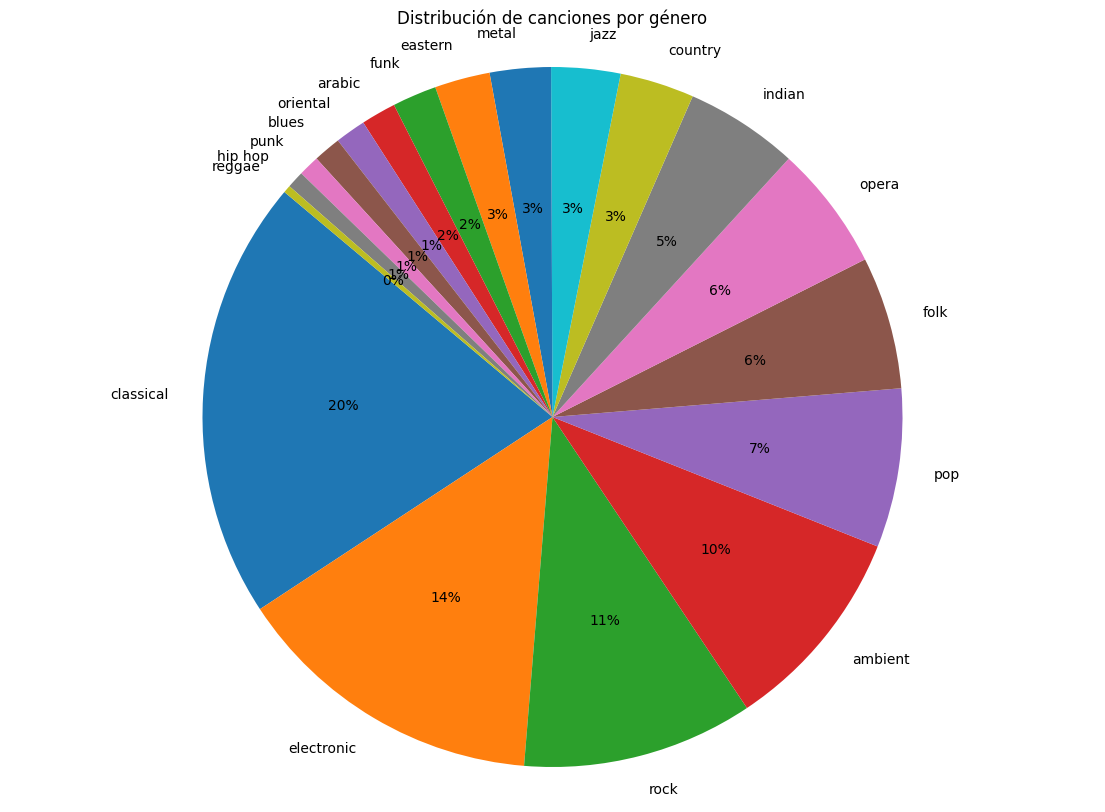

In [46]:
def visualize_genre_song_distribution(genres_per_genre):
    """Visualiza la distribución de canciones por género en un diagrama de tarta"""
    genres_per_genre = genres_per_genre.sort_values(by='value', ascending=False)
    plt.figure(figsize=(14, 10))
    plt.pie(genres_per_genre['value'], labels=genres_per_genre['variable'], autopct='%1.0f%%', startangle=140)
    plt.title('Distribución de canciones por género')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

visualize_genre_song_distribution(genres_per_genre)

In [48]:
def get_number_of_songs_per_tag(tags_df):
    """Devuelve el número de canciones por tag."""
    tags_df['song_id'] = tags_df['mp3_path'].apply(_extract_song_id)
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])
    tags_df = tags_df.groupby("song_id").agg(lambda x: x.sum() > 0).reset_index()
    print("Número de canciones totales:", tags_df.shape[0])
    tags_df = tags_df.drop(columns=["song_id"])
    print("Número de canciones con sólo un tag:", tags_df[tags_df.sum(axis=1) == 1].shape[0])
    print("Número de canciones con dos tags:", tags_df[tags_df.sum(axis=1) == 2].shape[0])
    print("Número de canciones con tres tags:", tags_df[tags_df.sum(axis=1) == 3].shape[0])
    print("Número de canciones con más de tres tags:", tags_df[tags_df.sum(axis=1) > 3].shape[0])
    
    tags_df = tags_df.melt()
    tags_df = tags_df.groupby("variable").agg({"value": "sum"}).reset_index()
    print("Número de canciones por tag:")
    return tags_df
tags_per_tag = get_number_of_songs_per_tag(tags_df)
print(tags_per_tag)

Número de canciones totales: 4825
Número de canciones con sólo un tag: 373
Número de canciones con dos tags: 564
Número de canciones con tres tags: 767
Número de canciones con más de tres tags: 3046
Número de canciones por tag:
           variable  value
0          acoustic    133
1   acoustic guitar     38
2              airy     55
3             banjo    112
4             beats   1021
..              ...    ...
71            water     34
72            weird    372
73             wind     71
74         woodwind     81
75            world     55

[76 rows x 2 columns]


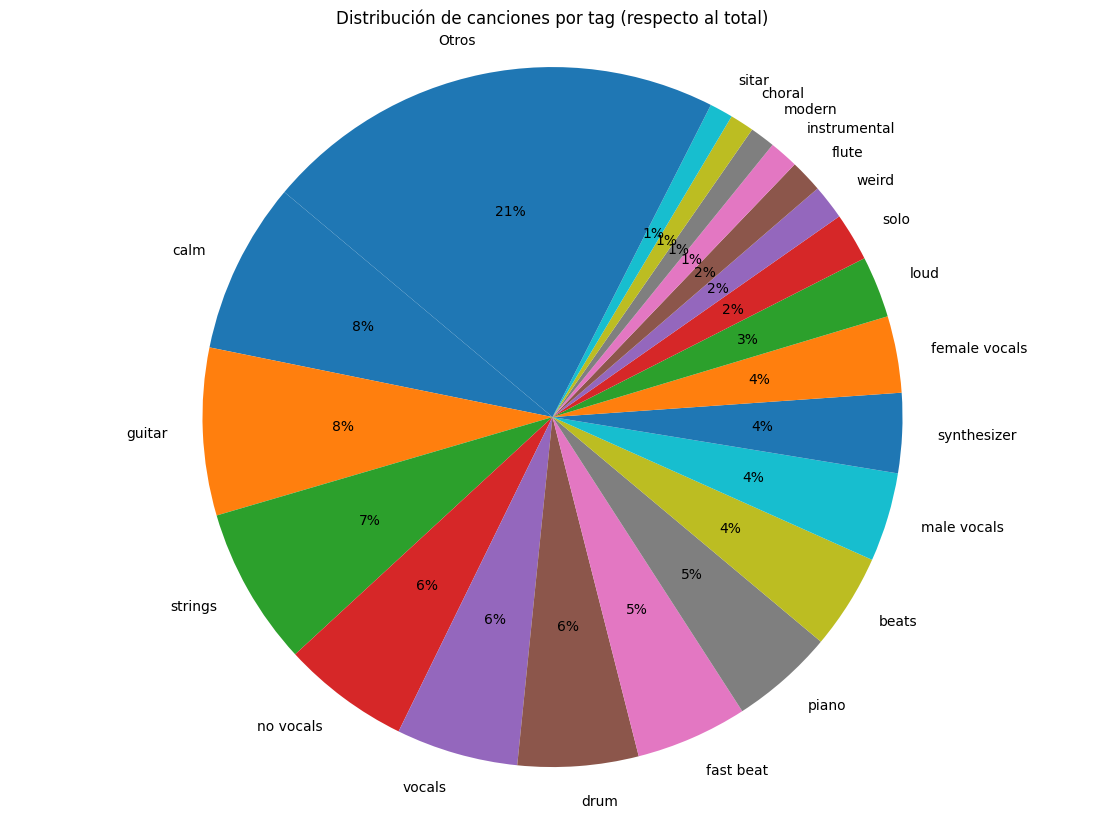

In [57]:
def visualize_tag_song_distribution(tags_per_tag, n=20):
    """Visualiza la distribución de canciones por los n tags más frecuentes frente al total en un diagrama de tarta"""
    tags_per_tag = tags_per_tag.sort_values(by='value', ascending=False)

    total_value = tags_per_tag['value'].sum()

    top_tags = tags_per_tag.head(n)
    other_value = tags_per_tag['value'].iloc[n:].sum()

    # Crear nuevos valores y etiquetas
    values = list(top_tags['value']) + ([other_value] if other_value > 0 else [])
    labels = list(top_tags['variable']) + (['Otros'] if other_value > 0 else [])

    plt.figure(figsize=(14, 10))
    plt.pie(
        values,
        labels=labels,
        autopct=lambda p: f'{p:.0f}%' if p > 0 else '',  # Mostrar porcentajes bonitos
        startangle=140
    )
    plt.title('Distribución de canciones por tag (respecto al total)')
    plt.axis('equal')  # Círculo perfecto
    plt.show()

visualize_tag_song_distribution(tags_per_tag)

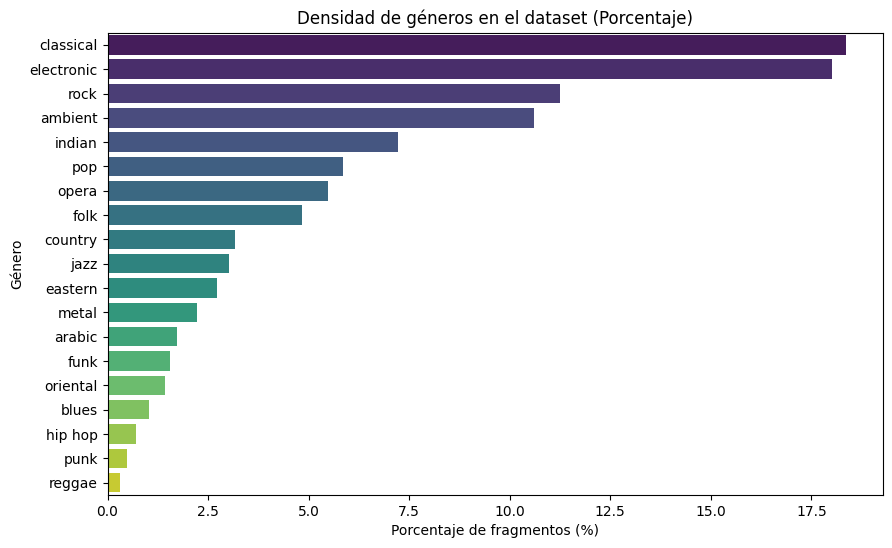

In [4]:
def visualize_density_genres(genres_df):
    """Visualiza la distribución relativa de géneros en el dataset."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])

    # Asegurarse de que todos los valores sean numéricos
    genres_df = genres_df.apply(pd.to_numeric, errors='coerce')

    genres_density = genres_df.sum(axis=0)

    total_fragments = genres_density.sum()
    genres_density = (genres_density / total_fragments) * 100

    genres_density = genres_density.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=genres_density.values,
        y=genres_density.index,
        hue=genres_density.index,
        palette="viridis",
        legend=False
    )
    plt.title("Densidad de géneros en el dataset (Porcentaje)")
    plt.xlabel("Porcentaje de fragmentos (%)")
    plt.ylabel("Género")
    plt.show()
visualize_density_genres(genres_df)

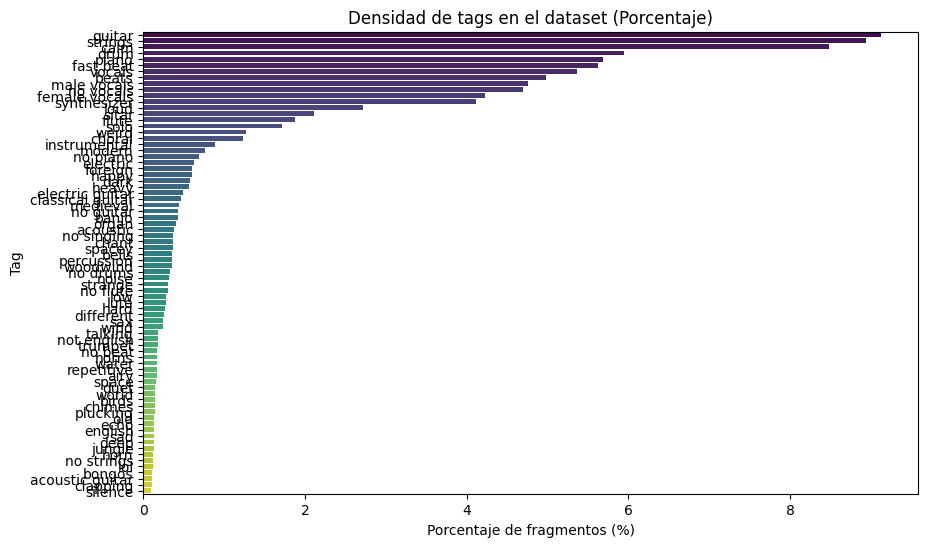

In [5]:
def visualize_density_tags(tags_df):
    """Visualiza la distribución relativa de tags en el dataset."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])
    tags_density = tags_df.sum(axis=0)

    total_fragments = tags_density.sum()
    tags_density = (tags_density / total_fragments) * 100
    tags_density = tags_density.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=tags_density.values, y=tags_density.index, hue=tags_density.index, palette="viridis", legend=False)
    plt.title("Densidad de tags en el dataset (Porcentaje)")
    plt.xlabel("Porcentaje de fragmentos (%)")
    plt.ylabel("Tag")
    plt.show()
visualize_density_tags(tags_df)

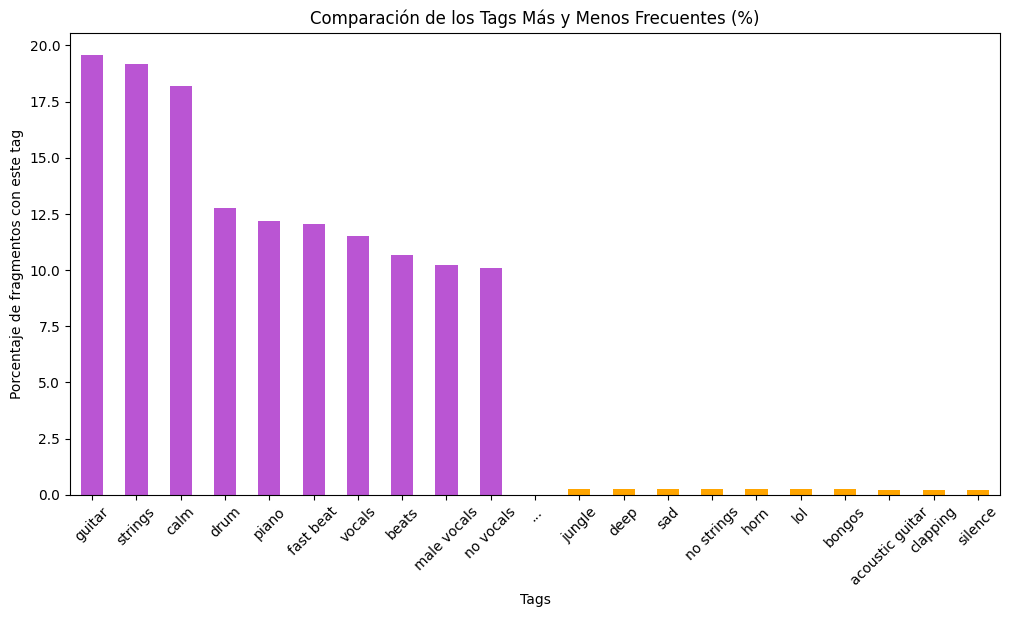

In [6]:
def visualize_stacked_bar(tags_df, top_n=10):
    """Muestra un gráfico de barras con los N tags más frecuentes a la izquierda,
    un separador en el centro y los N menos frecuentes a la derecha en orden descendente."""

    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    top_distribution = tags_df[top_tags].sum() / tags_df.shape[0] * 100

    separator = pd.Series([np.nan], index=["..."])

    bottom_tags = tags_df.sum().sort_values(ascending=True).head(top_n).index[::-1]
    bottom_distribution = tags_df[bottom_tags].sum() / tags_df.shape[0] * 100

    full_distribution = pd.concat([top_distribution, separator, bottom_distribution])

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ["mediumorchid"] * top_n + ["gray"] + ["orange"] * top_n

    full_distribution.plot(kind="bar", color=colors, ax=ax)

    plt.title("Comparación de los Tags Más y Menos Frecuentes (%)")
    plt.xlabel("Tags")
    plt.ylabel("Porcentaje de fragmentos con este tag")
    plt.xticks(rotation=45)
    plt.show()
visualize_stacked_bar(tags_df)

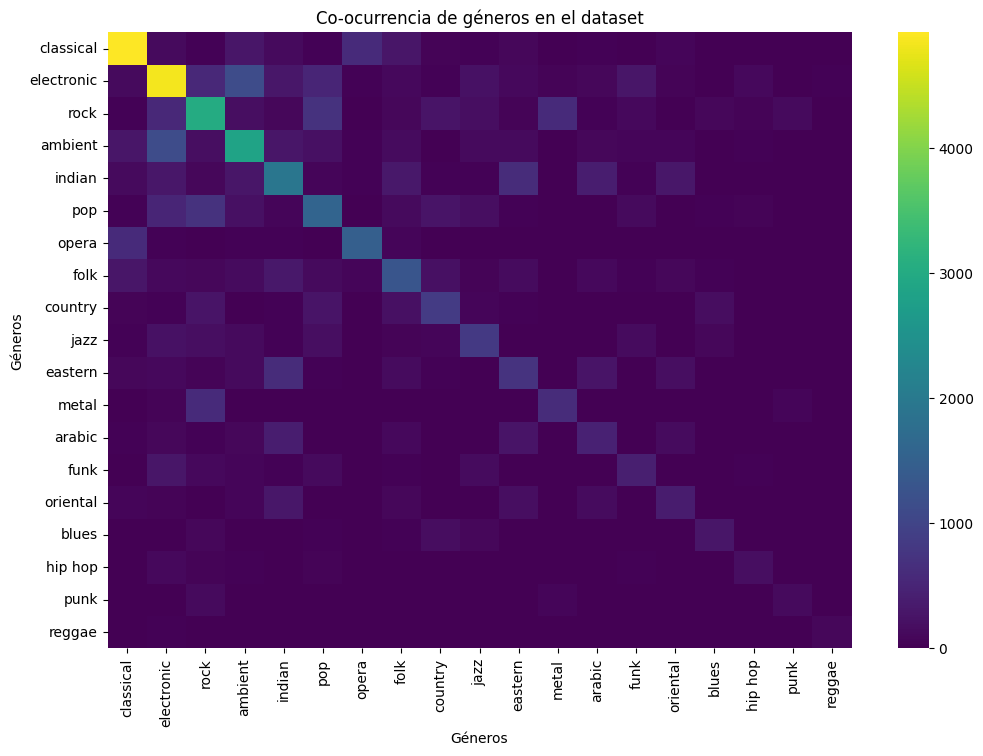

In [7]:
def visualize_genre_co_occurrence(genres_df, top_n=30):
    """Muestra una matriz de co-ocurrencia entre los géneros más frecuentes."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])

    top_genres = genres_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = genres_df[top_genres]
    correlation_matrix = filtered_df.T.dot(filtered_df)

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap="viridis", annot=False)
    plt.title("Co-ocurrencia de géneros en el dataset")
    plt.xlabel("Géneros")
    plt.ylabel("Géneros")
    plt.show()
visualize_genre_co_occurrence(genres_df, top_n=30)

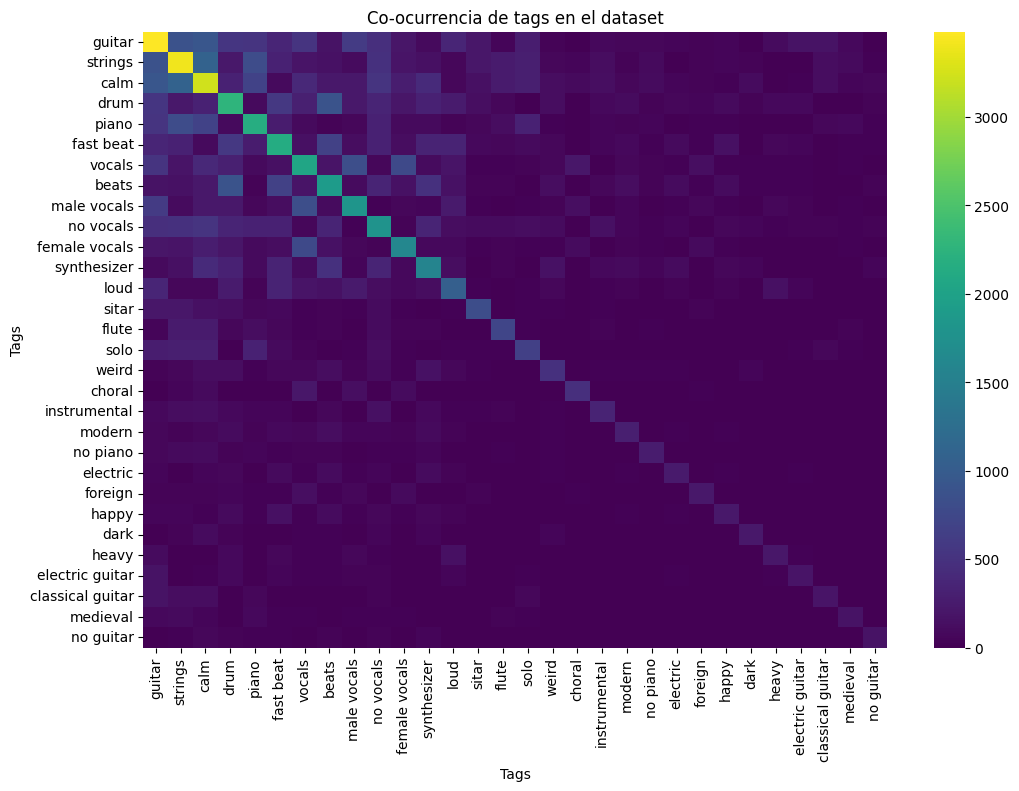

In [8]:
def visualize_tag_co_occurrence(tags_df, top_n=30):
    """Muestra una matriz de co-ocurrencia entre los tags más frecuentes."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = tags_df[top_tags]
    correlation_matrix = filtered_df.T.dot(filtered_df)

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap="viridis", annot=False)
    plt.title("Co-ocurrencia de tags en el dataset")
    plt.xlabel("Tags")
    plt.ylabel("Tags")
    plt.show()
visualize_tag_co_occurrence(tags_df)

### Correlación entre variables

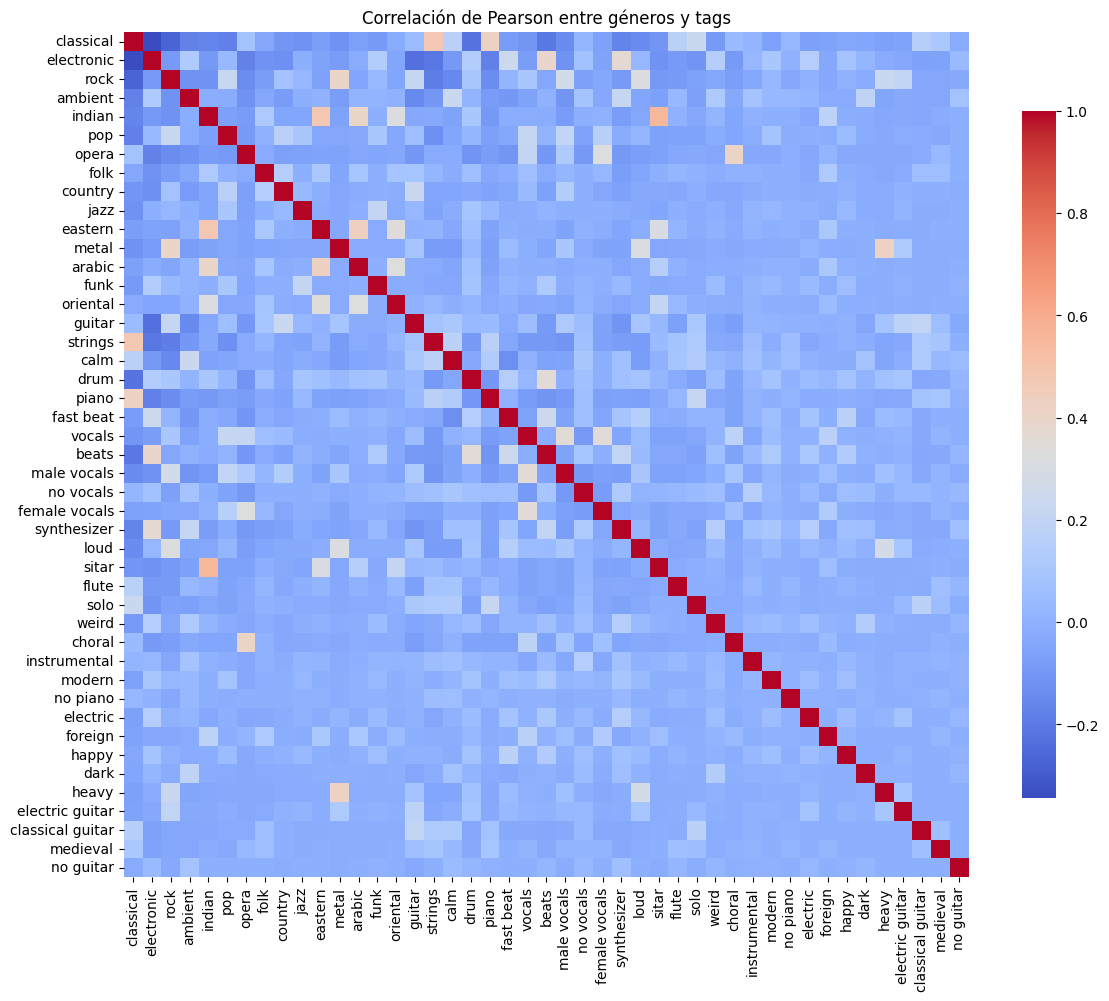

In [10]:
def visualize_pearson_correlation(genres_df, tags_df, n=15, m=30):
    """Visualiza la correlación de Pearson entre los géneros y los tags más frecuentes."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_genres = genres_df.sum().sort_values(ascending=False).head(n).index
    top_tags = tags_df.sum().sort_values(ascending=False).head(m).index

    filtered_genres = genres_df[top_genres]
    filtered_tags = tags_df[top_tags]

    merged_df = pd.concat([filtered_genres, filtered_tags], axis=1)
    correlation_matrix = merged_df.corr(method='pearson')

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, square=True, cbar_kws={"shrink": .8})
    plt.title("Correlación de Pearson entre géneros y tags")
    plt.tight_layout()
visualize_pearson_correlation(genres_df, tags_df, n=15, m=30)

In [11]:
def visualize_pearson_correlation_dataframe(genres_df, tags_df):
    """Visualiza la correlación de Pearson entre géneros y tags."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    merged_df = pd.concat([genres_df, tags_df], axis=1)
    correlation_matrix = merged_df.corr(method='pearson')


    display(correlation_matrix)
visualize_pearson_correlation_dataframe(genres_df, tags_df)

,classical,jazz,folk,ambient,electronic,opera,country,funk,arabic,eastern,...,electric,no strings,no piano,no beat,no singing,no guitar,no vocals,no flute,no drums,not english
classical,1.000000,-0.117216,-0.042217,-0.176291,-0.344653,0.078044,-0.107234,-0.088613,-0.070834,-0.075882,...,-0.069229,-0.004905,0.027298,-0.012941,0.013718,-0.029422,0.021802,0.024350,0.021691,-0.019223
jazz,-0.117216,1.000000,-0.008607,-0.007280,-0.004460,-0.061775,0.034406,0.211108,-0.006866,-0.019411,...,0.006979,-0.000767,-0.001957,-0.013351,0.013669,-0.007013,-0.004318,-0.007444,-0.015179,-0.013849
folk,-0.042217,-0.008607,1.000000,-0.035263,-0.116406,-0.025460,0.143904,-0.009413,0.095638,0.107627,...,-0.031034,-0.010242,-0.012589,-0.010026,0.013664,-0.008997,-0.004954,-0.006302,0.002248,0.078181
ambient,-0.176291,-0.007280,-0.035263,1.000000,0.124502,-0.113790,-0.086925,0.009068,0.007961,0.003382,...,0.012529,0.037289,0.029910,0.086881,-0.002961,0.078251,0.083218,0.011074,0.040397,-0.017901
electronic,-0.344653,-0.004460,-0.116406,0.124502,1.000000,-0.173630,-0.124790,0.133640,-0.023164,-0.059212,...,0.143932,0.032624,-0.002697,0.006424,0.012026,0.040341,0.075484,-0.003070,0.009199,-0.018586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
no guitar,-0.029422,-0.007013,-0.008997,0.078251,0.040341,-0.005480,-0.016084,0.000527,-0.004633,-0.005112,...,0.024307,0.006492,-0.006851,-0.005889,0.024393,1.000000,0.028286,-0.000378,0.013007,-0.006108
no vocals,0.021802,-0.004318,-0.004954,0.083218,0.075484,-0.093067,-0.011875,0.012042,-0.013466,0.006160,...,0.038314,0.015514,-0.006537,0.028721,0.127384,0.028286,1.000000,-0.005823,0.003139,-0.021195
no flute,0.024350,-0.007444,-0.006302,0.011074,-0.003070,-0.008774,-0.004767,-0.003187,-0.008670,-0.002393,...,-0.009415,-0.004135,-0.009784,0.006685,0.000710,-0.000378,-0.005823,1.000000,0.018543,0.006088
no drums,0.021691,-0.015179,0.002248,0.040397,0.009199,-0.003274,0.000102,-0.008632,-0.013726,0.016552,...,0.007603,-0.004331,-0.010249,0.005934,0.000014,0.013007,0.003139,0.018543,1.000000,-0.005327
